## CO2 Sequestration in NYC Street Trees Between 1995 and 2015

#### How much CO2 did NYC's dominant tree species store in a 20 year period?

### Methods 
* Identify which species included most of the large (above average dbh) trees in the city in 1995 and 2015.
* Determine CO2 stored by these species in 1995 and 2015 using process described by the US Forest Service. 
* Visualize results with bar and pie charts. 

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib.colors as mcolors

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
os.chdir('C:/Users/roseh/Desktop/785/tree_census/Data')

In [5]:
# read in all dataframes

tree_1995 = pd.read_csv('1995_Street_Tree_Census.csv')
tree_2015 = pd.read_csv('2015_Street_Tree_Census.csv')

### Tidy and Explore Data

In [6]:
os.chdir('C:/Users/roseh/Desktop/785/tree_census')

In [7]:
# equations require dbh in centimeters
# add new column to dataframes converting dbh measurement from inches to centimeters

tree_1995['dbh_cm'] = tree_1995['Diameter']*2.54
tree_2015['dbh_cm'] = tree_2015['tree_dbh']*2.54

# drop rows with na values
tree_1995 = tree_1995.dropna(axis=0, how='any')
tree_2015 = tree_2015.dropna(axis=0, how='any')

# rename dbh column to match
tree_1995.rename(columns={'Diameter':'tree_dbh'}, inplace=True)

In [8]:
# create boxplot to visualize changes in dbh

def plot_dbh(df):
    """"Create boxplot comparing dbh of trees in 1995 and 2015""" 
    
    fig,ax = plt.subplots(figsize=(5,3))                                              

    sns.boxplot(data=df[['1995','2015']],
                ax=ax,
                orient='h', 
                flierprops={"marker": "o"}, 
                fliersize=1)
    ax.set_title('Tree Diameter (inches)')
    plt.savefig('images/boxplot.png')
    plt.show()

C:\Users\roseh\miniconda3\envs\rs-env\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


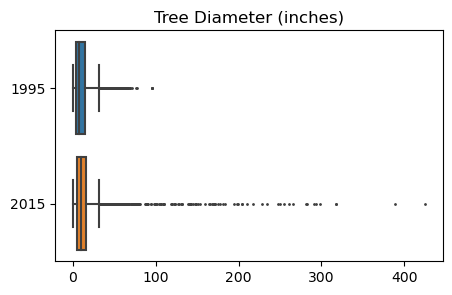

In [9]:
dbh_df = pd.DataFrame({'1995':tree_1995['tree_dbh'],'2015':tree_2015['tree_dbh']}) 
plot_dbh(dbh_df)

* The large outlier values seem strange. The [NYC Tree Census summary](https://www.nycgovparks.org/trees/treescount) states that the largest trees counted were between 57-87 inches in diameter.

### Remove Outliers

In [10]:
def remove_outliers(df):
    """Return dataframe containing only trees with dbh < upper bound of IQR"""
    
    q75,q25 = np.percentile(df['tree_dbh'],[75,25])
    intr_qr = q75-q25
 
    upper = q75+(1.5*intr_qr)
    
    return df[df['tree_dbh'] < upper]

In [11]:
tree_1995_n = remove_outliers(tree_1995)

In [12]:
tree_2015_n = remove_outliers(tree_2015)

C:\Users\roseh\miniconda3\envs\rs-env\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


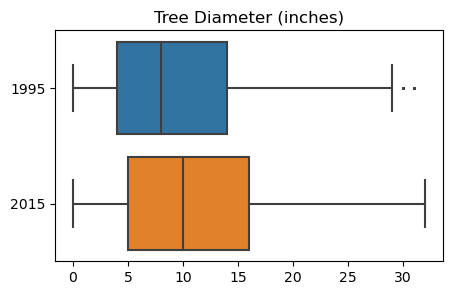

In [13]:
dbh_df_n = pd.DataFrame({'1995':tree_1995_n['tree_dbh'],'2015':tree_2015_n['tree_dbh']})
plot_dbh(dbh_df_n)

In [14]:
# print mean and median dbh for each year

print('\t1995\nTree count:', len(tree_1995_n),'\nMean dbh:',np.around(tree_1995_n['tree_dbh'].mean(),2),'\nMedian dbh:',tree_1995_n['tree_dbh'].median())
print('\n\t2015\nTree count:', len(tree_2015_n),'\nMean dbh:',np.around(tree_2015_n['tree_dbh'].mean(),2),'\nMedian dbh:',tree_2015_n['tree_dbh'].median())

print(f'\nNYC gained {len(tree_2015_n) - len(tree_1995_n)} new trees between 1995 and 2015')

	1995
Tree count: 249674 
Mean dbh: 9.93 
Median dbh: 8.0

	2015
Tree count: 627752 
Mean dbh: 11.09 
Median dbh: 10.0

NYC gained 378078 new trees between 1995 and 2015


### Which species have the most trees with above average dbh?

In [15]:
# select only trees with (dbh > mean) and create new dataframes

mean_dbh_95 = tree_1995_n['tree_dbh'].mean()
mean_dbh_15 = tree_2015_n['tree_dbh'].mean()

largest_1995 = tree_1995_n[tree_1995_n['tree_dbh'] > mean_dbh_95]
largest_2015 = tree_2015_n[tree_2015_n['tree_dbh'] > mean_dbh_15]

In [16]:
largest_2015['spc_common'].unique()

array(['pin oak', 'American linden', 'London planetree', 'honeylocust',
       'willow oak', 'sycamore maple', 'American elm', 'ash',
       'Amur maple', 'red maple', 'ginkgo', 'silver maple',
       'Norway maple', 'tulip-poplar', 'Sophora', 'Callery pear',
       'scarlet oak', 'Atlantic white cedar', 'crab apple', 'sweetgum',
       'Ohio buckeye', 'silver linden', 'swamp white oak',
       'Japanese zelkova', 'pignut hickory', 'mulberry',
       'northern red oak', 'littleleaf linden', 'horse chestnut',
       'black oak', 'green ash', 'Japanese tree lilac', 'golden raintree',
       'weeping willow', 'black walnut', 'Chinese elm', 'black locust',
       'Siberian elm', 'southern red oak', 'crimson king maple',
       'sugar maple', 'Oklahoma redbud', 'tree of heaven', 'cherry',
       'black cherry', 'eastern cottonwood', "Schumard's oak",
       'American hornbeam', 'eastern redcedar', 'catalpa', 'boxelder',
       'white ash', 'holly', 'Japanese snowbell', 'Kentucky coffeetree'

In [17]:
# standardize names of top 10 species for convenience

names_95 = {'LONDON PLANETREE': 'London Planetree', 'MAPLE, NORWAY': 'Norway Maple', 'OAK, PIN': 'Pin Oak', 'MAPLE, SUGAR': 'Sugar Maple',
         'MAPLE, RED': 'Red Maple', 'HONEYLOCUST': 'Honeylocust', 'LINDEN, LITTLE LEAF': 'Linden', 'MAPLE, SYCAMORE': 'Sycamore Maple',
            'GINKGO': 'Ginkgo', 'MAPLE, SILVER': 'Silver Maple', 'ASH, GREEN': 'Green Ash', 'ZELKOVA, JAPANESE': 'Japanese Zelkova'}

names_15 = {'London planetree': 'London Planetree', 'Norway maple': 'Norway Maple', 'pin oak': 'Pin Oak', 'MAPLE, SUGAR': 'Sugar Maple',
         'red maple': 'Red Maple', 'honeylocust': 'Honeylocust', 'littleleaf linden': 'Linden', 'MAPLE, SYCAMORE': 'Sycamore Maple',
            'GINKGO': 'Ginkgo', 'silver maple': 'Silver Maple', 'Callery pear': 'Callery Pear', 'green ash': 'Green Ash',
           'Japanese zelkova': 'Japanese Zelkova'}

largest_1995['Spc_Common'] = largest_1995['Spc_Common'].replace(names_95)
largest_2015['spc_common'] = largest_2015['spc_common'].replace(names_15)

In [18]:
top_species_1995 = largest_1995['Spc_Common'].value_counts().head(10)     # define top 10 species in 1995 
top_species_1995_df = pd.DataFrame(top_species_1995).reset_index()

In [19]:
top_species_1995_df

,index,Spc_Common
0,London Planetree,40177
1,Norway Maple,20408
2,Pin Oak,8962
3,Silver Maple,5323
4,Sugar Maple,4312
5,Red Maple,4197
6,Honeylocust,3961
7,Linden,3026
8,Sycamore Maple,2054
9,Ginkgo,1756


In [20]:
top_species_2015 = largest_2015['spc_common'].value_counts().head(10)     # define top 10 species in 2015
top_species_2015_df = pd.DataFrame(top_species_2015).reset_index()

In [21]:
# Define list of Kelly's 22 Colors of Maximum Contrast
colors = ['#F2F3F4', '#222222', '#F3C300', '#875692', '#F38400', '#A1CAF1', '#BE0032', '#C2B280',
          '#848482', '#008856','#E68FAC', '#0067A5', '#F99379', '#604E97', '#F6A600', '#B3446C',
          '#DCD300', '#882D17', '#8DB600', '#654522', '#E25822', '#2B3D26']
colors = colors[9:]

species_95 = set(top_species_1995.index.unique())
species_15 = set(top_species_2015.index.unique())
species = list(species_95 | species_15)

color_dict = dict(zip(species,colors))

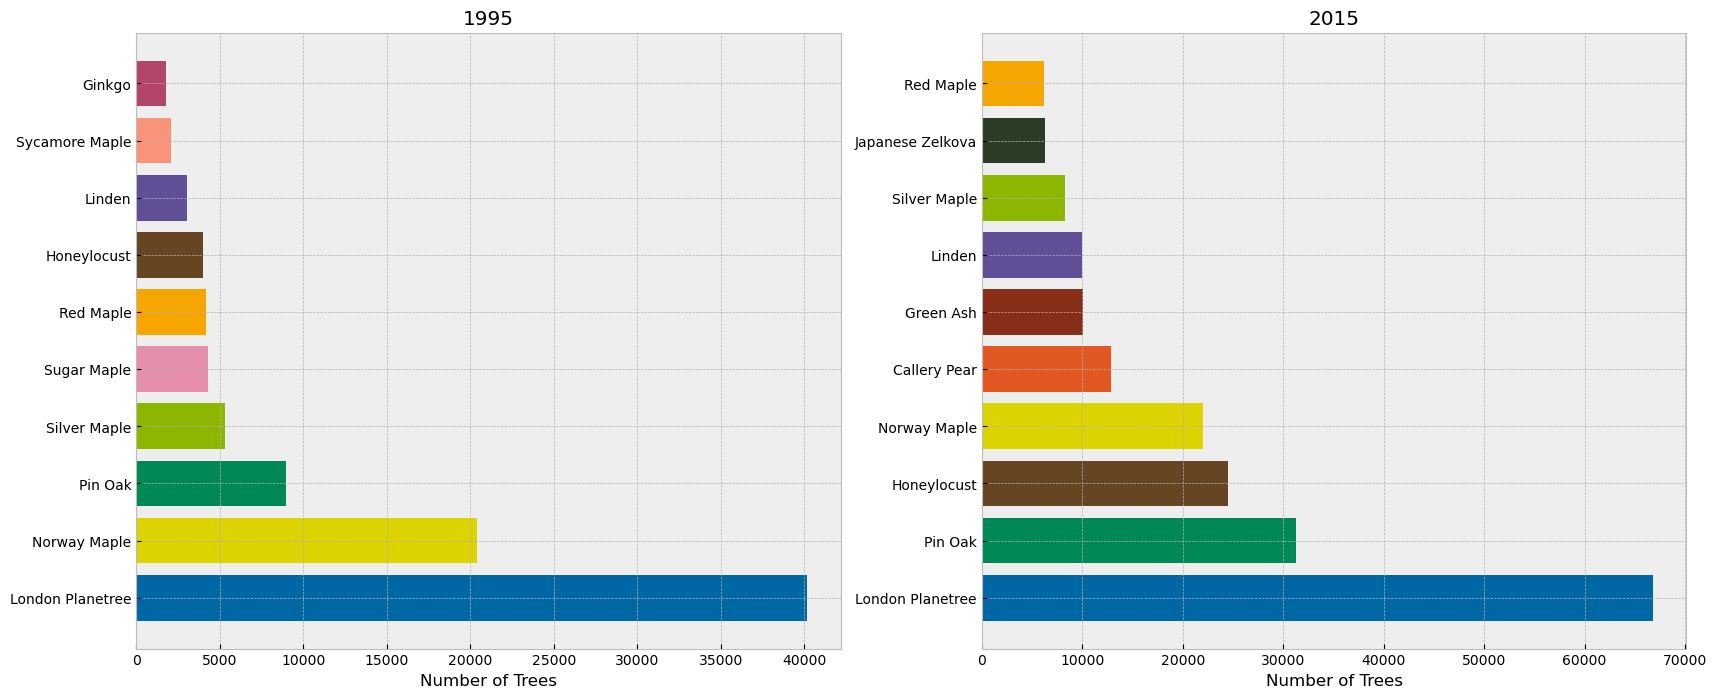

In [24]:
# plot bar charts showing tree counts for top species each year

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
plt.style.use('bmh')
ax1.barh(top_species_1995.index.str.title(),top_species_1995, color=top_species_1995_df['index'].replace(color_dict))
ax1.set_title('1995')
ax1.set_xlabel('Number of Trees')

ax2.barh(top_species_2015.index.str.title(),top_species_2015, color=top_species_2015_df['index'].replace(color_dict))
ax2.set_title('2015')
ax2.set_xlabel('Number of Trees')

plt.savefig(os.path.join('images', 'species_counts_resize.png'), bbox_inches= 'tight')
plt.show()

- In both years, most of the larger trees in the city were London Planetrees. 
- Sycamore Maple, Ginkgo, and Sugar Maple appear only in 1995.
- They are replaced by Japanese Zelkova, Green Ash and Callery Pear in 2015.

### How Much CO2 Was stored by these Species Between 1995 and 2015?

According to the USDA [Urban Tree Database](https://www.fs.usda.gov/psw/publications/documents/psw_gtr253/psw_gtr_253.pdf), the process for calculating the amount of CO2 sequestered in a tree is as follows:
- Find the aboveground dry weight biomass of the tree by using the species appropriate allometric equation.
- Multiply the this biomass by 1.28 to incorporate belowground biomass.
- Multiply by the constant 0.5 to convert to total carbon stored in kg.
- Multiply by the constant 3.67 (the molecular weight of CO2) to convert to the total CO2 stored in kg.

In [86]:
# define list of species in alphabetical order
species = list(top_species_2015.index.unique())
species.sort()
species = species[1:]   # remove Callery Pear as no allometric equation is available for this species

In [24]:
species

['Green Ash',
 'Honeylocust',
 'Japanese Zelkova',
 'Linden',
 'London Planetree',
 'Norway Maple',
 'Pin Oak',
 'Red Maple',
 'Silver Maple']

In [25]:
# select only trees with dbh greater than 0 (to avoid zero division error in some allometric equations)

greater_than_0_1995 = tree_1995_n[tree_1995_n['tree_dbh']>0]
greater_than_0_2015 = tree_2015_n[tree_2015_n['tree_dbh']>0]

# standardize species names

greater_than_0_1995['Spc_Common'] = greater_than_0_1995['Spc_Common'].replace(names_95)
greater_than_0_2015['spc_common'] = greater_than_0_2015['spc_common'].replace(names_15)

# group the dataframes by species
species_groups_1995 = greater_than_0_1995.groupby('Spc_Common')
species_groups_2015 = greater_than_0_2015.groupby('spc_common')

In [26]:
# define all allometric functions and append to list in alphabetical order

functions = []

greenash_function = lambda x: (0.0005885*x**2.206) * 530  # equation for volume, multiplied by density factor
functions.append(greenash_function)

honeylocust_function = lambda x: (0.0005055*x**2.22) * 600  # equation for volume, multiplied by density factor
functions.append(honeylocust_function)

japanesezelkova_function = lambda x: (0.0000502*x**2.674757) * 520    # equation for volume, multiplied by density factor
functions.append(japanesezelkova_function)

linden_function = lambda x: (0.0009359*x**2.042) * 420     # equation for volume, multiplied by density factor
functions.append(linden_function)

londonplane_function = lambda x: (0.000059*x**2.673578) * 500    # equation for volume, multiplied by density factor
functions.append(londonplane_function)

norwaymaple_function = lambda x: (0.0019421*x**1.785) * 520      # equation for volume, multiplied by density factor
functions.append(norwaymaple_function)

# no specific function available; using general equation for maple/oak/hickory/beech
pinoak_function = lambda x: np.exp(-2.0127+2.4342*np.log(x))- np.exp((-4.0813+5.8816/x))
functions.append(pinoak_function)

redmaple_function = lambda x: 0.1970*x**2.1933             # equation for dry weight biomass
functions.append(redmaple_function)

silvermaple_function = lambda x: (0.000363*x**2.292) * 440       # equation for volume, multiplied by density factor
functions.append(silvermaple_function)

In [27]:
def get_carbon_storage(df):
    """Apply allometric equation to corresponding tree species and add dry weight biomass column
    and CO2 storage column to dataframe. Return a list of updated dataframes."""
    
    function_count = 0
    group_list = []

    for s in species:
        func = functions[function_count]
       
        group = df.get_group(s)
        group['dw_biomass'] = group['dbh_cm'].apply(func)
        group['CO2'] = group['dw_biomass']*1.28*.5*3.67
        print(f'Completed {s}')
        group_list.append(group)
    
        function_count += 1
        
    return group_list

In [28]:
new_1995 = get_carbon_storage(species_groups_1995)    # apply function to 1995 data

Completed Green Ash
Completed Honeylocust
Completed Japanese Zelkova
Completed Linden
Completed London Planetree
Completed Norway Maple
Completed Pin Oak
Completed Red Maple
Completed Silver Maple


In [29]:
new_2015 = get_carbon_storage(species_groups_2015)   # apply function to 2015 data

Completed Green Ash
Completed Honeylocust
Completed Japanese Zelkova
Completed Linden
Completed London Planetree
Completed Norway Maple
Completed Pin Oak
Completed Red Maple
Completed Silver Maple


In [30]:
# read total CO2 storage for each species each year into new dataframe

co2_1995 = []
co2_2015 = []

for df in new_1995:
    co2_1995.append(df['CO2'].sum())
    
for df in new_2015:
    co2_2015.append(df['CO2'].sum())
    
co2_storage = pd.DataFrame({'species':species,'1995':co2_1995,'2015':co2_2015})
co2_storage['CO2_difference'] = co2_storage['2015'] - co2_storage['1995']
co2_storage.set_index('species',inplace=True)

In [31]:
co2_storage

,1995,2015,CO2_difference
species,,,
Green Ash,4.798472e+06,3.343112e+07,2.863265e+07
Honeylocust,1.054612e+07,8.164495e+07,7.109883e+07
Japanese Zelkova,4.841764e+05,1.059925e+07,1.011507e+07
Linden,7.115164e+06,2.694056e+07,1.982540e+07
London Planetree,1.017896e+08,2.567524e+08,1.549627e+08
Norway Maple,4.166090e+07,5.336202e+07,1.170113e+07
Pin Oak,3.138268e+07,1.852929e+08,1.539102e+08
Red Maple,8.210575e+06,1.568451e+07,7.473932e+06
Silver Maple,1.521434e+07,3.447348e+07,1.925914e+07


In [89]:
co2_storage['CO2_difference'].sort_values()

species
Red Maple           7.473932e+06
Japanese Zelkova    1.011507e+07
Norway Maple        1.170113e+07
Silver Maple        1.925914e+07
Linden              1.982540e+07
Green Ash           2.863265e+07
Honeylocust         7.109883e+07
Pin Oak             1.539102e+08
London Planetree    1.549627e+08
Name: CO2_difference, dtype: float64

### Visualize the Results
- The three species that showed the greatest increase in CO2 storage over the 20 year period were Pin Oak, London Plane, and Honeylocust. 
- In both years, Londonplane trees stored the most CO2. This species stored 1.02x10^8 kg of CO2 in 1995 and 2.57x10^8 kg in 2015. 

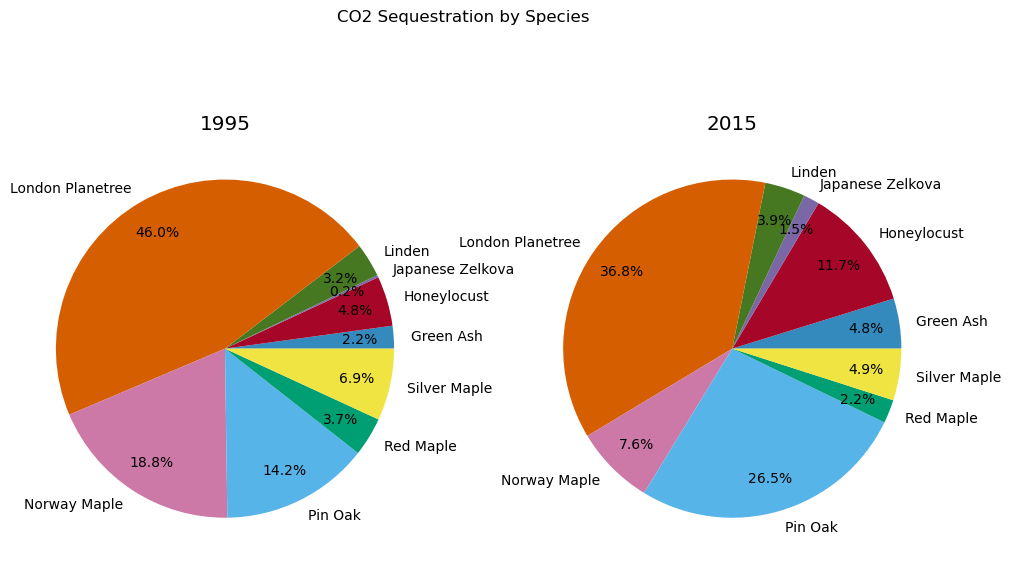

In [81]:
# create pie charts to show relative co2 storage by each species

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,7))
fig.suptitle('CO2 Sequestration by Species')

ax1.pie(co2_storage['1995'],labels=co2_storage.index,autopct='%1.1f%%',pctdistance=.8,labeldistance=1.1)
ax1.set_title('1995')

ax2.pie(co2_storage['2015'],labels=co2_storage.index, autopct='%1.1f%%',pctdistance=.8,labeldistance=1.1)
ax2.set_title('2015')

plt.savefig(os.path.join('images','co2_piecharts.png'))
plt.show()
                    

In [33]:
# create barchart to show absolute co2 storage by species

by_year = co2_storage.T                                # transpose dataframe
#by_year.drop('CO2_difference',axis=0,inplace=True)

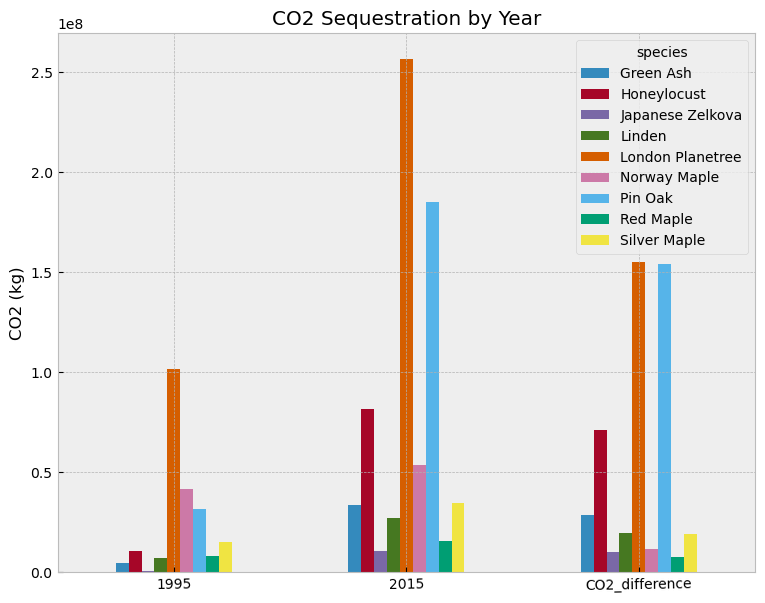

In [87]:
by_year.plot(kind='bar',figsize=(9,7),rot=1,title='CO2 Sequestration by Year',ylabel='CO2 (kg)')

plt.savefig(os.path.join('images','co2_barchart.png'))
plt.show()